In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import scipy.stats


root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils


In [2]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [4]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

#### Overall accuracy of the 16-way classifier

Text(0.5, 1.0, '16-way logistic regression classifier, overall acc')

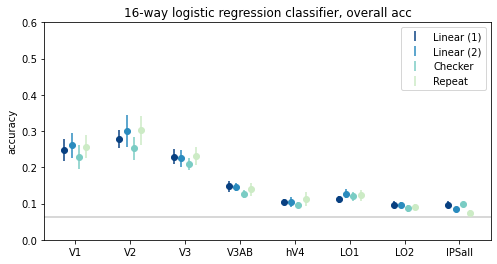

In [5]:
ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.2, 0.2, 4)

plt.figure(figsize=(8,4))

plt.axhline(1/16, color=[0.8, 0.8, 0.8])

lh = []

for ti in ti_plot:

    x_ticks = np.arange(n_rois) + x_jitter[ti]

    vals = dec_withintask['acc_bytask'][:,:,ti]
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

    plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
    h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
    lh.append(h)

plt.ylim([0, 0.6])

plt.xticks(np.arange(n_rois), roi_names)
plt.ylabel('accuracy')

plt.legend(lh,np.array(task_names)[ti_plot])

plt.title('16-way logistic regression classifier, overall acc')


#### Accuracy versus c (regularization)

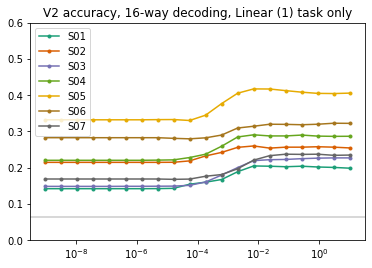

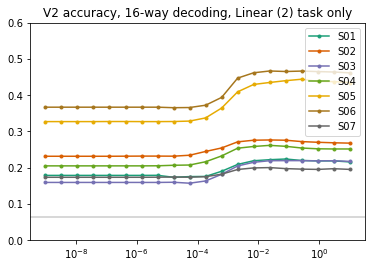

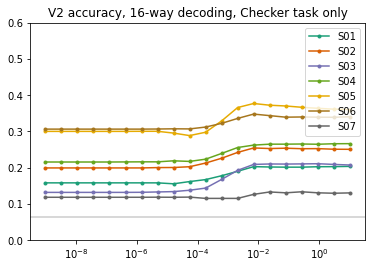

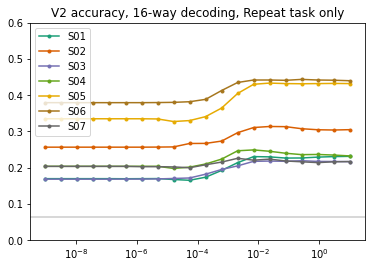

In [6]:
rr = 1;

c_values = np.logspace(-9, 1, 20)
# for rr in range(n_rois):
# for rr in [0,1,2,3]:
for ti in range(4):

    plt.figure()

    for si in range(n_subjects):

        vals = np.nanmean(dec_withintask['acc_each_cval'][si, rr, ti, :, :], axis=0)

        plt.plot(c_values, vals, '.-', color=subcolors[si,:], )

    plt.gca().set_xscale('log')
    plt.legend(['S%02d'%ss for ss in subjects])

    plt.ylim([0, 0.6])
    plt.axhline(1/16, color=[0.8, 0.8, 0.8])
    plt.title('%s accuracy, 16-way decoding, %s task only'%(roi_names[rr], task_names[ti]))

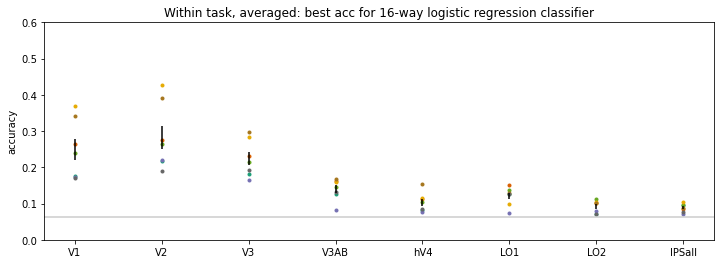

In [8]:
vals = np.mean(dec_withintask['acc_bytask'], axis=2)

n_subj = vals.shape[0]
n_rois = vals.shape[1]
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subj)
plt.figure(figsize=(12,4))
plt.errorbar(np.arange(n_rois), meanvals, semvals, linestyle='none',color='k', zorder=10)
for si in range(n_subj):
    plt.plot(np.arange(n_rois), vals[si,:], '.', color=subcolors[si,:])
plt.xticks(np.arange(n_rois), roi_names);
plt.ylim([0, 0.6])
plt.axhline(1/16, color=[0.8, 0.8, 0.8])
plt.ylabel('accuracy')
plt.title('Within task, averaged: best acc for 16-way logistic regression classifier');

In [7]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

#### Get accuracy for each boundary separately
determine whether it differs across tasks

Using all main grid trials

In [45]:

center = 2.5

# binary acc for each boundary (Linear-1, Linear-2, Checker)
acc2_eachbound = np.zeros((n_subjects, n_rois, 4, 3))
dprime2_eachbound = np.zeros((n_subjects, n_rois, 4, 3))

# for the two linear tasks, can also consider the 4 pts along each axis individually
r_eachbound = np.zeros((n_subjects, n_rois, 4, 2))
acc4_eachbound = np.zeros((n_subjects, n_rois, 4, 2))

# Note: using just main trials here, otherwise tasks are not directly comparable bc points differ

for si, ss in enumerate(subjects):
 
    for ti, tt in enumerate([1,2,3,4]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        for ii in [0,1,2]:

            categ_actual = l['categ_task%d'%(ii+1)]
            
            if ii<2:
                # actual labels for position along this axis
                coord_actual = pt_labs[:,ii].round(2)
            else:
                coord_actual = None

            for ri in range(n_rois):

                pred = dec_withintask['preds_all'][si][ri][ti].astype(int)
                
                # figure out what points these 16 values correspond to
                coords_pred = grid_pts[pred,:].round(2)
                
                # binarize the predictions of 16-way classifier into 2 categories
                # based on current axis "ii"
                categ_pred = grid_utils.get_categ(coords_pred, (ii+1))
                
                if ii<2:
                    coord_pred = coords_pred[:,ii]
                else:
                    coord_pred = None
                    
                inds = is_main_grid
                
                d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
                dprime2_eachbound[si,ri,ti,ii] = d;
                
                # 2-way acc
                a = np.mean(categ_pred[inds]==categ_actual[inds])
                acc2_eachbound[si,ri,ti,ii] = a;
                
                if ii<2:

                    r,p = scipy.stats.pearsonr(coord_actual[inds], coord_pred[inds])
                    r_eachbound[si,ri,ti,ii] = r;

                    # 4-way acc
                    a = np.mean(coord_pred[inds]==coord_actual[inds])
                    acc4_eachbound[si,ri,ti,ii] = a;
        
         

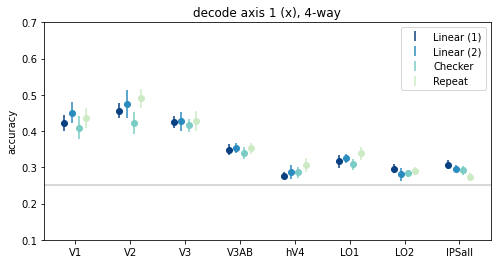

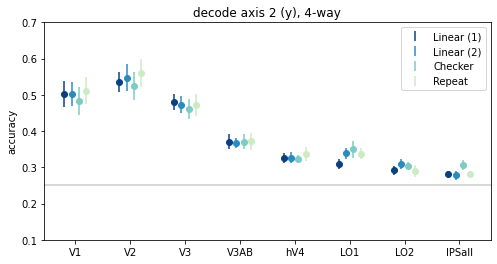

In [46]:
ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.2, 0.2, 4)


for bi, axis_name in enumerate(['axis 1 (x)', 'axis 2 (y)']):

    avals = acc4_eachbound[:,:,:,bi]

    plt.figure(figsize=(8,4))
    
    plt.axhline(1/4, color=[0.8, 0.8, 0.8])
    
    lh = []

    for ti in ti_plot:

        x_ticks = np.arange(n_rois) + x_jitter[ti]

        vals = avals[:,:,ti]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    plt.ylim([0.1, 0.7])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('accuracy')

    plt.legend(lh,np.array(task_names)[ti_plot])

    plt.title('decode %s, 4-way'%axis_name)


#### compare just the two linear conditions

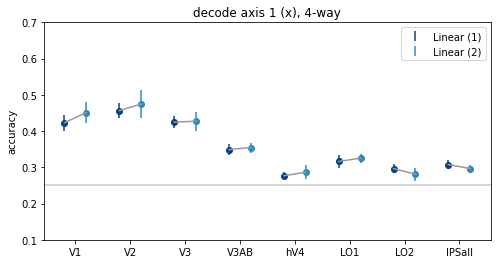

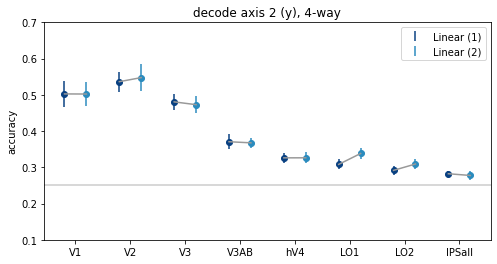

In [47]:
ti_plot = [0,1]

x_jitter = np.linspace(-0.2, 0.2, 2)


for bi, axis_name in enumerate(['axis 1 (x)', 'axis 2 (y)']):

    avals = acc4_eachbound[:,:,:,bi]

    plt.figure(figsize=(8,4))
    
    plt.axhline(1/4, color=[0.8, 0.8, 0.8])
    
    lh = []

    for ti in ti_plot:

        x_ticks = np.arange(n_rois) + x_jitter[ti]

        vals = avals[:,:,ti]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    for ri in range(n_rois):
            
        meanvals = np.mean(avals[:,ri,ti_plot], axis=0)
        plt.plot(ri+x_jitter, meanvals,'-',color=[0.6, 0.6, 0.6])

    plt.ylim([0.1, 0.7])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('accuracy')

    plt.legend(lh,np.array(task_names)[ti_plot])

    plt.title('decode %s, 4-way'%axis_name)

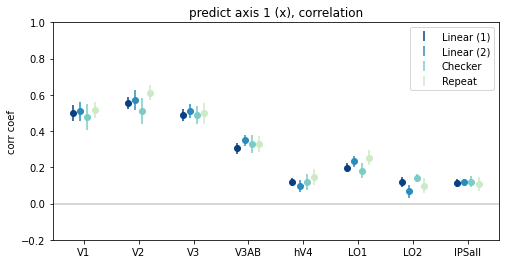

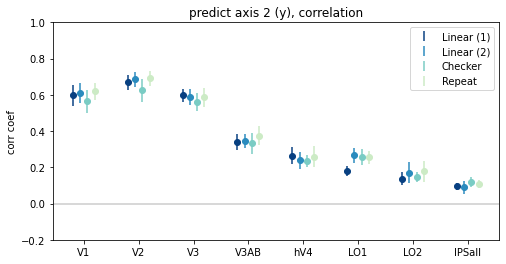

In [48]:
ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.2, 0.2, 4)


for bi, axis_name in enumerate(['axis 1 (x)', 'axis 2 (y)']):

    rvals = r_eachbound[:,:,:,bi]

    plt.figure(figsize=(8,4))
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []

    for ti in ti_plot:

        x_ticks = np.arange(n_rois) + x_jitter[ti]

        vals = rvals[:,:,ti]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    plt.ylim([-0.2, 1.0])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('corr coef')

    plt.legend(lh,np.array(task_names)[ti_plot])

    plt.title('predict %s, correlation'%axis_name)


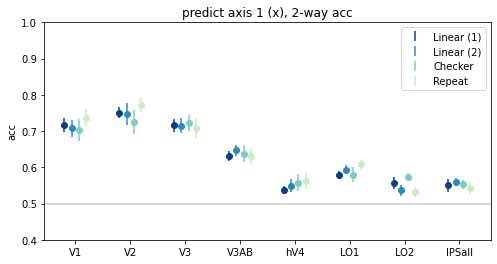

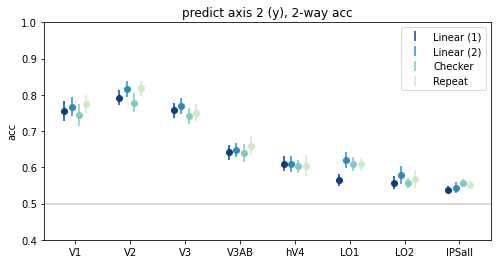

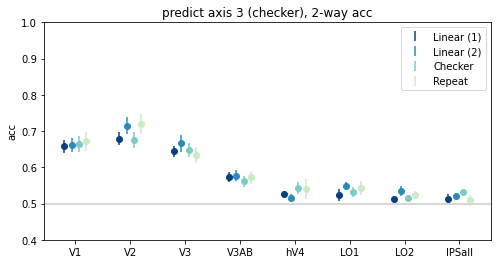

In [49]:
ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.2, 0.2, 4)


for bi, axis_name in enumerate(['axis 1 (x)', 'axis 2 (y)', 'axis 3 (checker)']):

    avals = acc2_eachbound[:,:,:,bi]

    plt.figure(figsize=(8,4))
    
    plt.axhline(1/2, color=[0.8, 0.8, 0.8])
    
    lh = []

    for ti in ti_plot:

        x_ticks = np.arange(n_rois) + x_jitter[ti]

        vals = avals[:,:,ti]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    plt.ylim([0.4, 1.0])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('acc')

    plt.legend(lh,np.array(task_names)[ti_plot])

    plt.title('predict %s, 2-way acc'%axis_name)


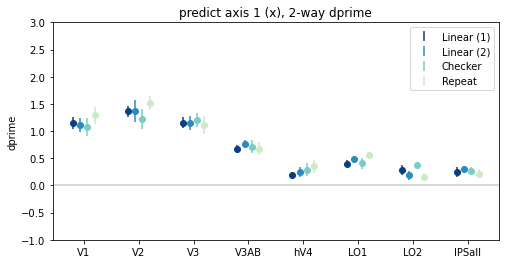

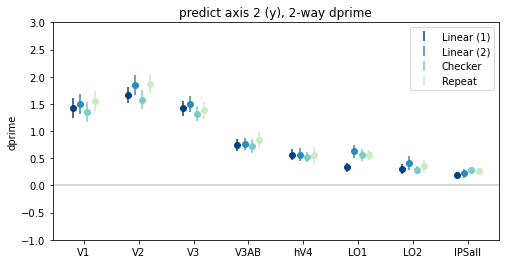

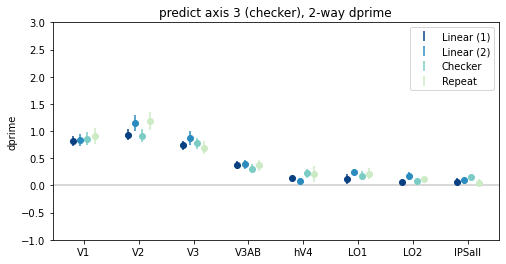

In [50]:
ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.2, 0.2, 4)


for bi, axis_name in enumerate(['axis 1 (x)', 'axis 2 (y)', 'axis 3 (checker)']):

    dvals = dprime2_eachbound[:,:,:,bi]

    plt.figure(figsize=(8,4))
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []

    for ti in ti_plot:

        x_ticks = np.arange(n_rois) + x_jitter[ti]

        vals = dvals[:,:,ti]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    plt.ylim([-1, 3])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('dprime')

    plt.legend(lh,np.array(task_names)[ti_plot])

    plt.title('predict %s, 2-way dprime'%axis_name)
